In [1]:
import pandas as pd
import numpy as np
import os
import sys
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Dict, List, Optional, Set, Union
import unicodedata

# Configure pandas to display all columns
pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.entities.lineup import Lineup, Player, Position

from src.db.nst_db_utils import *
from src.db.nhl_db_utils import get_player_full_name, insert_player_data
from src.data_processing.nst_scraper import *
from src.data_processing.pbp_utils import *
from src.data_processing.game_utils import *
from src.data_processing.team_utils import *
from src.data_processing.player_utils import *

In [2]:
goalie_stats = get_goalie_stats(
    start_date="2024-10-01",
    end_date="2025-01-31",
    table_name="goalie_stats_5v5"
)

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.


In [3]:
goalie_stats

,date,player,team,toi,shots_against,saves,goals_against,sv_pct,gaa,gsaa,xg_against,hd_shots_against,hd_saves,hd_goals_against,hdsv_pct,md_shots_against,md_saves,md_goals_against,mdsv_pct,ld_shots_against,ld_saves,ld_goals_against,ldsv_pct,rush_attempts_against,rebound_attempts_against,avg_shot_distance,avg_goal_distance
0,2025-01-31,Daniil Tarasov,CBJ,50.23,24,23,1,0.958,1.19,1.52,2.66,5,4,1,0.8,3,3,0,1.0,16,16,0,1.0,1,8,37.92,10.0
1,2025-01-31,Thatcher Demko,VAN,46.75,12,10,2,0.833,2.57,-0.74,1.54,5,3,2,0.6,2,2,0,1.0,5,5,0,1.0,3,3,31.0,11.0
2,2025-01-31,Mackenzie Blackwood,COL,49.57,16,16,0,1.0,0.0,1.68,1.35,3,3,0,1.0,6,6,0,1.0,7,7,0,1.0,4,2,31.81,NaN
3,2025-01-31,Karel Vejmelka,UTA,50.23,16,14,2,0.875,2.39,-0.32,0.96,2,1,1,0.5,2,2,0,1.0,11,10,1,0.909,0,2,42.13,21.0
4,2025-01-31,Jake Oettinger,DAL,46.75,17,15,2,0.882,2.57,-0.22,1.39,4,3,1,0.75,0,0,0,NaN,11,10,1,0.909,1,2,51.24,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,2024-10-08,Petr Mrazek,CHI,50.7,24,20,4,0.833,4.73,-1.15,2.57,9,7,2,0.778,8,7,1,0.875,6,5,1,0.833,1,6,33.29,26.25
1726,2024-10-05,Devon Levi,BUF,45.43,26,24,2,0.923,2.64,-0.14,2.54,6,4,2,0.667,7,7,0,1.0,12,12,0,1.0,3,6,31.0,11.0
1727,2024-10-05,Jake Allen,NJD,45.43,16,15,1,0.938,1.32,0.14,1.39,3,2,1,0.667,1,1,0,1.0,11,11,0,1.0,1,4,46.19,7.0
1728,2024-10-04,Jacob Markstrom,NJD,46.72,26,25,1,0.962,1.28,1.31,2.59,5,4,1,0.8,5,5,0,1.0,15,15,0,1.0,3,7,41.46,16.0


In [4]:
db_prefix = 'NHL_DB_'

def extract_team_goalies(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.
    
    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.
    
    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id, back_to_back = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbreviations to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    elif team.upper() == 'UTA':
        # Since UTA did not exist in the previous season, match with ARI
        if 'ARI' == away_team_code.upper():
            team_side = 'Away'
            skaters = away_skaters
            goalies = away_goalies
        elif 'ARI' == home_team_code.upper():
            team_side = 'Home'
            skaters = home_skaters
            goalies = home_goalies
        else:
            raise ValueError(f"Team '{team}' not found in game ID {game_id}.")
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")
    print(f"Back to back: {back_to_back}")
    lineup.back_to_back = back_to_back  # Assign back_to_back to the Lineup

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# col_lineup = extract_team_lineup('COL', '2024-12-10')

In [5]:
def get_pregame_matchup_stats(input_date: str, team: str, last_n: int=None, team_stats_df: pd.DataFrame=None) -> Dict[str, Any]:
    """
    Retrieves and compiles pre-game statistics for both teams in a matchup.
    
    This function performs the following steps:
    1. Calculates reference date and retrieves team statistics
    2. Identifies the matchup game and opponent team
    3. Compiles team-level statistics for both teams
    4. Identifies starting goalies for both teams
    
    Args:
        input_date (str): The game date in 'YYYY-MM-DD' format
        team (str): The three-letter team code (e.g., 'TOR')
        last_n (int, optional): Number of previous games to consider for team statistics
        team_stats_df (pd.DataFrame, optional): Pre-loaded team statistics DataFrame. If None, will fetch new data
    
    Returns:
        pd.DataFrame: A DataFrame with two rows (one per team) containing:
            - Game context (date, game_id, home/away)
            - Team statistics
            - Starting goalie information (name, team, id)
    """
    try:
        # Step 1a: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 1b: If team_stats_df is not provided, fetch them
        if team_stats_df is None or team_stats_df.empty:
            team_stats_df = nst_team_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                stype=2,
                sit='all',
                last_n=last_n
            )

        # Step 3: Retrieve matchup games for the input date
        print(f"Retrieving matchup games for date {input_date}.")
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        # Initialize variables
        game_id = None
        opponent_team_tricode = None
        side = None

         # Step 4: Identify the game_id involving the specified team
        for gid, gdate in zip(game_ids, game_dates):
            print(f"Checking Game ID: {gid} on Date: {gdate}")
            boxscore = get_game_boxscore(gid, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            print(f"Away Team: {away_team}, Home Team: {home_team}")
            
            if team.upper() == away_team.upper():
                opponent_team_tricode = home_team.upper()
                game_id = gid
                side = 'A'
                print(f"Team {team} found as Away Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                # Check back-to-back status for both teams
                _, team_b2b = get_most_recent_game_id(team, input_date)
                _, opponent_b2b = get_most_recent_game_id(opponent_team_tricode, input_date)
                break
            elif team.upper() == home_team.upper():
                opponent_team_tricode = away_team.upper()
                game_id = gid
                side = 'H'
                print(f"Team {team} found as Home Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                # Check back-to-back status for both teams
                _, team_b2b = get_most_recent_game_id(team, input_date)
                _, opponent_b2b = get_most_recent_game_id(opponent_team_tricode, input_date)
                break

        if not game_id or not opponent_team_tricode:
            raise ValueError(f"Team {team} did not play on {input_date} or could not determine opponent.")
        
        # Step 5: Get full names for both teams
        team_fullname = get_fullname_by_tricode(team)
        opponent_team_fullname = get_fullname_by_tricode(opponent_team_tricode)

        if team_fullname is None or opponent_team_fullname is None:
            raise ValueError(f"Could not find full names for teams: {team} or {opponent_team_tricode}")
        
        # Remove accent marks and punctuation from both team names
        team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        opponent_team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', opponent_team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        
        # Create matchup DataFrame - Modified section
        if 'team' not in team_stats_df.columns:
            raise KeyError("Column 'team' not found in team_stats_df. Please verify the scraped data.")

        # Filter stats for both teams
        team_row = team_stats_df[team_stats_df['team'].str.lower() == team_fullname.lower()]
        opponent_row = team_stats_df[team_stats_df['team'].str.lower() == opponent_team_fullname.lower()]
        
        if team_row.empty or opponent_row.empty:
            raise ValueError(f"Could not find statistics for one or both teams")
            
        # Create a new DataFrame with team names but opponent stats
        matchup_df = pd.DataFrame()
        
        # First row: Keep team name but use opponent's stats
        first_row = opponent_row.copy()
        first_row['team'] = team
        
        # Second row: Keep opponent name but use team's stats
        second_row = team_row.copy()
        second_row['team'] = opponent_team_tricode
        
        # Combine rows
        matchup_df = pd.concat([first_row, second_row])
        
        # Add additional context columns
        matchup_df['home'] = [side == 'H', side == 'A']
        matchup_df['game_id'] = game_id
        matchup_df['game_date'] = input_date
        matchup_df['b2b'] = [team_b2b, opponent_b2b]  # First row has team's b2b, second row has opponent's b2b
        matchup_df['opp_b2b'] = [opponent_b2b, team_b2b]  # First row has opponent's b2b, second row has team's b2b

        # Convert team names to tricodes
        matchup_df['team'] = [team, opponent_team_tricode]

        # Drop specified columns
        columns_to_drop = ['gp', 'toi', 'w', 'l', 'otl', 'row', 'points', 'point_%']
        matchup_df = matchup_df.drop(columns=columns_to_drop, errors='ignore')

        # Reorder columns to put game_date and game_id first
        cols = matchup_df.columns.tolist()
        cols = ['game_date', 'game_id', 'home'] + [col for col in cols if col not in ['game_date', 'game_id', 'home']]
        matchup_df = matchup_df[cols]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
    
        # Get goalie information for both teams
        goalie_info = []
        for idx, row in matchup_df.iterrows():
            try:
                # If the game is in the past, just read the goalie from the boxscore
                if input_date < datetime.now().strftime('%Y-%m-%d'):
                    boxscore = get_game_boxscore(row['game_id'], clean=False)
                    # Use awayTeam for first row (idx=0), homeTeam for second row (idx=1)
                    team_type = 'awayTeam' if idx == 0 else 'homeTeam'
                    goalies = boxscore['playerByGameStats'][team_type]['goalies']
                    
                    if goalies:
                        # Sort goalies by TOI (descending) and take the one with most ice time
                        starting_goalie = max(goalies, key=lambda x: x.get('toi', '00:00'))
                        if starting_goalie.get('toi') != '00:00':
                            goalie_name = get_player_full_name(starting_goalie.get('playerId'), 'NHL_DB_', suppress_log=True)
                            if goalie_name is None:
                                player_data = fetch_player_data(starting_goalie.get('playerId'))
                                if player_data:
                                    insert_player_data(player_data, 'NHL_DB_')
                                goalie_name = get_player_full_name(starting_goalie.get('playerId'), 'NHL_DB_', suppress_log=True)
                            goalie_info.append({
                                'goalie_name': goalie_name,
                                'goalie_team': row['team'],
                                'goalie_id': starting_goalie.get('playerId')
                            })
                        else:
                            goalie_info.append({
                                'goalie_name': None,
                                'goalie_team': None,
                                'goalie_id': None
                            })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
                else:
                    lineup = extract_team_goalies(row['team'], input_date)
                    if lineup.goalies[0] is not None:  # Get starting goalie
                        goalie = lineup.goalies[0]
                        goalie_info.append({
                            'goalie_name': goalie.name,
                            'goalie_team': goalie.team,
                            'goalie_id': goalie.player_id
                        })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
            except Exception as e:
                print(f"Error getting goalie for {row['team']}: {e}")
                goalie_info.append({
                    'goalie_name': None,
                    'goalie_team': None,
                    'goalie_id': None
                })
        
        # Add goalie information to matchup_df
        for col in ['goalie_name', 'goalie_team', 'goalie_id']:
            matchup_df[col] = [info[col] for info in goalie_info]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
        
        return matchup_df

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        return None

# # Example usage of the process_team_and_opponent function
input_date = '2025-02-08'
team = 'CHI'  # Example team code
matchup_data = get_pregame_matchup_stats(input_date, team, last_n=14)

Fetching data for reference date: 2025-02-07
Retrieving matchup games for date 2025-02-08.
Checking Game ID: 2024020876 on Date: 2025-02-08
Away Team: NJD, Home Team: MTL
Checking Game ID: 2024020877 on Date: 2025-02-08
Away Team: TBL, Home Team: DET
Checking Game ID: 2024020878 on Date: 2025-02-08
Away Team: UTA, Home Team: CAR
Checking Game ID: 2024020879 on Date: 2025-02-08
Away Team: VGK, Home Team: BOS
Checking Game ID: 2024020880 on Date: 2025-02-08
Away Team: OTT, Home Team: FLA
Checking Game ID: 2024020881 on Date: 2025-02-08
Away Team: PIT, Home Team: PHI
Checking Game ID: 2024020882 on Date: 2025-02-08
Away Team: NYR, Home Team: CBJ
Checking Game ID: 2024020883 on Date: 2025-02-08
Away Team: CHI, Home Team: STL
Team CHI found as Away Team in Game ID 2024020883. Opponent TriCode: STL


In [6]:
matchup_data

,game_date,game_id,home,team,cf,ca,cf%,ff,fa,ff%,sf,sa,sf%,gf,ga,gf%,xgf,xga,xgf%,scf,sca,scf%,scsf,scsa,scsf%,scgf,scga,scgf%,scsh%,scsv%,hdcf,hdca,hdcf%,hdsf,hdsa,hdsf%,hdgf,hdga,hdgf%,hdsh%,hdsv%,mdcf,mdca,mdcf%,mdsf,mdsa,mdsf%,mdgf,mdga,mdgf%,mdsh%,mdsv%,ldcf,ldca,ldcf%,ldsf,ldsa,ldsf%,ldgf,ldga,ldgf%,ldsh%,ldsv%,sh%,sv%,pdo,b2b,opp_b2b,goalie_name,goalie_team,goalie_id
0,2025-02-08,2024020883,False,CHI,316,345,47.81,230,265,46.46,151,183,45.21,8,19,29.63,16.74,19.24,46.53,153,170,47.37,82,88,48.24,6,15,28.57,7.32,82.95,59,73,44.70,33,42,44.00,3,7,30.0,9.09,83.33,94,97,49.21,49,46,51.58,3,8,27.27,6.12,82.61,196,198,49.75,60,83,41.96,2,3,40.00,3.33,96.39,5.30,89.62,0.949,1,0,Arvid Soderblom,CHI,8482821
1,2025-02-08,2024020883,True,STL,343,446,43.47,254,337,42.98,162,245,39.80,21,23,47.73,17.08,26.20,39.47,165,232,41.56,89,139,39.04,16,20,44.44,17.98,85.61,63,104,37.72,42,77,35.29,9,15,37.5,21.43,80.52,102,128,44.35,47,62,43.12,7,5,58.33,14.89,91.94,201,246,44.97,64,98,39.51,4,2,66.67,6.25,97.96,12.96,90.61,1.036,0,1,Jordan Binnington,STL,8476412


In [7]:
def calculate_goalie_rolling_stats(df, player_name: str, window_size: int = 10, date: str = None):
    """Create rolling averages and statistics for a specific goalie
    
    Args:
        df (pd.DataFrame): Input dataframe with goalie statistics
        player_name (str): Name of the player to process
        window_size (int, optional): Size of rolling window for statistics. Defaults to 10.
        date (str, optional): If provided, filter out data on or after this date
        
    Returns:
        pd.DataFrame: Processed statistics for the specified player or league averages if player not found
    """
    # Make a copy and filter for specific player
    player_df = df[df['player'] == player_name].copy()
    
    # If no data found for player, use league averages
    if player_df.empty:
        print(f"No data found for player: {player_name}. Using league averages.")
        
        # Calculate league averages
        league_df = df.copy()
        league_df['date'] = pd.to_datetime(league_df['date'])
        
        if date:
            cutoff_date = pd.to_datetime(date)
            league_df = league_df[league_df['date'] < cutoff_date]
        
        # Convert numeric columns from object to float
        numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                       'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
        for col in numeric_cols:
            league_df[col] = pd.to_numeric(league_df[col], errors='coerce')
        
        # Calculate league averages for all relevant columns
        feature_columns = [
            'shots_against', 'sv_pct', 'gaa', 'gsaa',
            'xg_against', 
            'hd_shots_against', 'hdsv_pct',
            'md_shots_against', 'mdsv_pct',
            'ld_shots_against', 'ldsv_pct'
        ]
        
        # Create a single row DataFrame with league averages
        league_averages = pd.DataFrame([{
            f'{col}_rolling_avg': league_df[col].mean() for col in feature_columns
        }])
        
        # Add standard deviations
        for col in feature_columns:
            league_averages[f'{col}_rolling_std'] = league_df[col].std()
        
        # Add workload features (use median values)
        league_averages['days_rest'] = 3.0  # typical rest between games
        league_averages['games_last_7'] = 2.0  # typical games in 7 days
        
        return league_averages
    
    # If we have player data, proceed with normal calculations
    player_df['date'] = pd.to_datetime(player_df['date'])
    player_df = player_df.sort_values('date')
    
    # Convert numeric columns from object to float
    numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                   'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
    for col in numeric_cols:
        player_df[col] = pd.to_numeric(player_df[col], errors='coerce')
    
    feature_columns = [
        'shots_against', 'sv_pct', 'gaa', 'gsaa',
        'xg_against', 
        'hd_shots_against', 'hdsv_pct',
        'md_shots_against', 'mdsv_pct',
        'ld_shots_against', 'ldsv_pct'
    ]
    
    try:
        print(f"Processing player: {player_name}")
        print(f"Data shape: {player_df.shape}")
        
        # Calculate rolling statistics
        for col in feature_columns:
            player_df[f'{col}_rolling_avg'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).mean()
            player_df[f'{col}_rolling_std'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).std()
        
        # Add workload features
        player_df['days_rest'] = player_df['date'].diff().dt.days
        player_df['games_last_7'] = player_df.rolling('7D', on='date')['date'].count()
        
        print(f"Successfully processed {player_name}")
        
        # Filter out dates if date is provided
        if date:
            cutoff_date = pd.to_datetime(date)
            player_df = player_df[player_df['date'] < cutoff_date]
            if player_df.empty:
                print(f"No data found for {player_name} before {date}. Using league averages.")
                return calculate_goalie_rolling_stats(df, player_name, window_size)  # Recursive call without date
            player_df = player_df.tail(1).reset_index(drop=True)

        # Keep only date, rolling features, and workload features
        rolling_cols = [col for col in player_df.columns if 'rolling' in col]
        cols_to_keep = ['date', 'player', 'team'] + rolling_cols + ['days_rest', 'games_last_7']
        player_df = player_df[cols_to_keep]
            
        return player_df
        
    except Exception as e:
        print(f"Error processing player {player_name}: {str(e)}")
        print("Data types:", player_df.dtypes)
        raise

In [8]:
def enrich_matchup_with_goalie_stats(
    matchup_df: pd.DataFrame,
    goalie_stats_df: pd.DataFrame,
    window_size: int = 10
) -> pd.DataFrame:
    """
    Enriches matchup data with rolling goalie statistics.
    
    Args:
        matchup_df (pd.DataFrame): Output from get_pregame_matchup_stats
        goalie_stats_df (pd.DataFrame): Raw goalie statistics
        window_size (int): Window size for rolling calculations
        
    Returns:
        pd.DataFrame: Enhanced matchup data with goalie rolling statistics
    """
    # Create a copy to avoid modifying original
    enriched_df = matchup_df.copy()
    
    # Process each goalie in the matchup
    for idx, row in enriched_df.iterrows():
        if pd.isna(row['goalie_name']):
            continue
            
        try:
            # Calculate rolling stats for this goalie
            goalie_rolling_stats = calculate_goalie_rolling_stats(
                goalie_stats_df,
                player_name=row['goalie_name'],
                window_size=window_size,
                date=row['game_date']
            )
            
            if not goalie_rolling_stats.empty:
                # Add prefix to rolling columns to avoid confusion with team stats
                rolling_cols = [col for col in goalie_rolling_stats.columns 
                              if col not in ['date', 'player', 'team']]
                
                for col in rolling_cols:
                    enriched_df.at[idx, f'g_{col}'] = goalie_rolling_stats.iloc[0][col]
                    
        except Exception as e:
            print(f"Error processing goalie {row['goalie_name']}: {e}")
            # Continue with next goalie if one fails
            continue
    
    return enriched_df

# matchup_data = enrich_matchup_with_goalie_stats(matchup_data, goalie_stats)

In [9]:
def get_matchup_goalie_results(matchup_df: pd.DataFrame) -> pd.DataFrame:
    """
    Retrieves actual game results for goalies from a matchup DataFrame.
    
    Args:
        matchup_df (pd.DataFrame): DataFrame containing matchup data with game_id column
        
    Returns:
        pd.DataFrame: Original matchup data with additional columns for actual game results
    """
    # Get the boxscore data
    game_id = matchup_df['game_id'].iloc[0]
    game_data = get_game_boxscore(game_id, clean=False)
    player_stats = game_data.get('playerByGameStats', {})
    
    # Create a copy of the input DataFrame
    enriched_df = matchup_df.copy()
    
    # Process each team's data
    for idx, row in enriched_df.iterrows():
        team_type = 'homeTeam' if row['home'] else 'awayTeam'
        goalies = player_stats.get(team_type, {}).get('goalies', [])
        
        if goalies:
            # Find the goalie whose name matches the one in enriched_df
            matching_goalie = None
            for g in goalies:
                goalie_name = get_player_full_name(g.get('playerId'), 'NHL_DB_', suppress_log=True)
                if goalie_name == row['goalie_name']:
                    matching_goalie = g
                    break
            
            # If no matching goalie found, use the first one (as before)
            goalie = matching_goalie or goalies[0]
            
            shots = goalie.get('shotsAgainst', 0)
            saves = goalie.get('saves', 0)
            
            enriched_df.loc[idx, 'res_saves'] = saves
            enriched_df.loc[idx, 'res_shots_against'] = shots
            enriched_df.loc[idx, 'res_save_pct'] = round(saves / shots if shots > 0 else 0.0, 3)
            enriched_df.loc[idx, 'res_goals_against'] = goalie.get('goalsAgainst', 0)
            enriched_df.loc[idx, 'res_decision'] = goalie.get('decision', 'N/A')
    
    return enriched_df

In [10]:
def process_matchups_for_date(input_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes all matchup games for a given date by getting matchup stats, 
    enriching with goalie stats, and getting actual game results.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date with 
                     pre-game stats and actual results
    """
    try:
        # Step 1: Get matchup games for the date
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        
        if not game_ids:
            print(f"No games found for the date {input_date}.")
            return pd.DataFrame()

        # Step 2: Get goalie stats for enrichment
        goalie_stats = get_goalie_stats(
            end_date=input_date,
            table_name="goalie_stats_5v5"
        )

        # Get team stats for matchup date so they are not scraped each time
        team_stats_df = nst_team_on_ice_scraper(
            startdate='',
            enddate=input_date,
            stype=2,
            sit='all',
            last_n=last_n
        )

        results = []
        
        # Step 3: Process each game
        for game_id in game_ids:
            print(f"\nProcessing Game ID: {game_id}")
            
            # Get boxscore to determine teams
            boxscore = get_game_boxscore(game_id, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            
            if not away_team or not home_team:
                print(f"Could not extract teams for Game ID: {game_id}. Skipping.")
                continue
                
            # Process away team
            try:
                matchup = get_pregame_matchup_stats(input_date, away_team, last_n=last_n, team_stats_df=team_stats_df)
                matchup = enrich_matchup_with_goalie_stats(matchup, goalie_stats)
                matchup = get_matchup_goalie_results(matchup)
                results.append(matchup)
            except Exception as e:
                print(f"Error processing away team {away_team}: {e}")

        # Combine all results
        if results:
            final_df = pd.concat(results, ignore_index=True)
            print("\nAll matchups processed successfully.")
            return final_df
        else:
            print("No matchups were successfully processed.")
            return pd.DataFrame()

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

In [11]:
# matchups = process_matchups_for_date('2024-12-10', last_n=15)

In [12]:
def process_matchups_for_date_range(start_date: str, end_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes matchup games for a range of dates by calling process_matchups_for_date for each date.
    
    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date range with 
                     pre-game stats and actual results
    """
    try:
        # Convert dates to datetime objects
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        
        # Generate list of dates
        dates = pd.date_range(start=start, end=end, freq='D')
        
        all_results = []
        
        # Process each date
        for date in dates:
            date_str = date.strftime('%Y-%m-%d')
            print(f"\nProcessing date: {date_str}")
            
            # Process matchups for this date
            daily_results = process_matchups_for_date(date_str, last_n=last_n)
            if not daily_results.empty:
                all_results.append(daily_results)

            time.sleep(random.randint(45, 60))
        
        # Combine all results
        if all_results:
            final_df = pd.concat(all_results, ignore_index=True)
            print(f"\nProcessed {len(dates)} days of matchups successfully.")
            return final_df
        else:
            print("No matchups were successfully processed for the date range.")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# Example usage:
# matchups_range = process_matchups_for_date_range('2023-10-10', '2023-10-31', last_n=15)

In [13]:
# matchups_range.to_csv('../data/g_15_10-01_23.csv', index=False)

In [15]:
# Get all csv files starting with 'g_15' in data directory
import os

data_dir = '../data'
csv_files = [f for f in os.listdir(data_dir) if f.startswith('g_15') and f.endswith('.csv')]

# Read and combine all matching CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    df['game_date'] = pd.to_datetime(df['game_date'])  # Convert date for sorting
    dfs.append(df)

# Concatenate all dataframes and sort by game_date
processed_df = pd.concat(dfs, ignore_index=True)
processed_df = processed_df.sort_values('game_date').reset_index(drop=True)

In [16]:
processed_df.tail(100)

,game_date,game_id,home,team,cf,ca,cf%,ff,fa,ff%,sf,sa,sf%,gf,ga,gf%,xgf,xga,xgf%,scf,sca,scf%,scsf,scsa,scsf%,scgf,scga,scgf%,scsh%,scsv%,hdcf,hdca,hdcf%,hdsf,hdsa,hdsf%,hdgf,hdga,hdgf%,hdsh%,hdsv%,mdcf,mdca,mdcf%,mdsf,mdsa,mdsf%,mdgf,mdga,mdgf%,mdsh%,mdsv%,ldcf,ldca,ldcf%,ldsf,ldsa,ldsf%,ldgf,ldga,ldgf%,ldsh%,ldsv%,sh%,sv%,pdo,b2b,opp_b2b,goalie_name,goalie_team,goalie_id,g_shots_against_rolling_avg,g_shots_against_rolling_std,g_sv_pct_rolling_avg,g_sv_pct_rolling_std,g_gaa_rolling_avg,g_gaa_rolling_std,g_gsaa_rolling_avg,g_gsaa_rolling_std,g_xg_against_rolling_avg,g_xg_against_rolling_std,g_hd_shots_against_rolling_avg,g_hd_shots_against_rolling_std,g_hdsv_pct_rolling_avg,g_hdsv_pct_rolling_std,g_md_shots_against_rolling_avg,g_md_shots_against_rolling_std,g_mdsv_pct_rolling_avg,g_mdsv_pct_rolling_std,g_ld_shots_against_rolling_avg,g_ld_shots_against_rolling_std,g_ldsv_pct_rolling_avg,g_ldsv_pct_rolling_std,g_days_rest,g_games_last_7,res_saves,res_shots_against,res_save_pct,res_goals_against,res_decision
1548,2025-01-25,2024020783,True,STL,512,561,47.72,361,403,47.25,240,253,48.68,22,20,52.38,27.41,26.61,50.74,249,258,49.11,130,116,52.85,19,15,55.88,14.62,87.07,116,96,54.72,72,53,57.60,14,9,60.87,19.44,83.02,133,162,45.08,58,63,47.93,5,6,45.45,8.62,90.48,302,344,46.75,96,118,44.86,3,5,37.5,3.13,95.76,9.17,92.09,1.013,0,1,Jordan Binnington,STL,8476412,20.9,6.100091,0.911600,0.097712,2.190000,2.322532,0.112,1.753072,1.564000,0.450511,4.300000,2.263233,0.828100,0.196409,5.0,2.211083,0.9300,0.115950,10.500000,5.038739,0.913500,0.164961,2.0,3.0,17.0,19.0,0.895,2.0,L
1549,2025-01-25,2024020784,False,CGY,362,445,44.86,270,338,44.41,178,233,43.31,16,26,38.10,18.42,23.36,44.08,173,190,47.66,102,114,47.22,13,18,41.94,12.75,84.21,67,76,46.85,40,57,41.24,6,15,28.57,15.00,73.68,106,114,48.18,62,57,52.10,7,3,70.00,11.29,94.74,216,304,41.54,72,108,40.00,2,8,20.0,2.78,92.59,8.99,88.84,0.978,0,0,Dustin Wolf,CGY,8481692,22.0,4.396969,0.951800,0.044529,1.394000,1.242061,0.663,0.861137,1.912000,0.577654,5.300000,1.251666,0.946600,0.086450,5.0,2.211083,0.9315,0.094010,10.500000,3.171050,0.970400,0.049334,5.0,2.0,21.0,25.0,0.840,4.0,W
1550,2025-01-25,2024020784,True,MIN,413,440,48.42,289,315,47.85,188,209,47.36,22,16,57.89,20.75,21.32,49.32,177,218,44.81,91,106,46.19,17,12,58.62,18.68,88.68,65,96,40.37,42,51,45.16,11,6,64.71,26.19,88.24,112,122,47.86,49,55,47.12,6,6,50.00,12.24,89.09,262,260,50.19,89,91,49.44,4,4,50.0,4.49,95.60,11.70,92.34,1.040,0,0,Marc-Andre Fleury,MIN,8470594,21.8,8.107610,0.914200,0.073575,2.623000,2.334895,0.068,1.174609,1.673000,0.928715,4.000000,2.828427,0.681556,0.274799,5.0,2.211083,1.0000,0.000000,11.600000,5.037636,0.918300,0.113401,2.0,2.0,24.0,29.0,0.828,5.0,L
1551,2025-01-25,2024020785,False,CAR,454,410,52.55,299,279,51.73,194,175,52.57,18,13,58.06,17.96,18.23,49.62,200,169,54.20,94,77,54.97,14,8,63.64,14.89,89.61,70,77,47.62,39,41,48.75,6,4,60.00,15.38,90.24,130,92,58.56,55,36,60.44,8,4,66.67,14.55,88.89,282,257,52.32,84,95,46.93,4,5,44.44,4.76,94.74,9.28,92.57,1.018,0,1,Pyotr Kochetkov,CAR,8481611,21.0,4.447221,0.914000,0.041169,2.199000,1.000460,0.037,0.763618,2.013000,0.484150,7.000000,2.624669,0.824700,0.113470,5.2,1.988858,0.9380,0.104952,7.600000,2.796824,0.977500,0.047799,4.0,2.0,24.0,27.0,0.889,3.0,O
1552,2025-01-25,2024020785,True,NYI,594,410,59.16,419,294,58.77,259,186,58.20,24,20,54.55,27.81,18.99,59.43,247,184,57.31,112,91,55.17,18,16,52.94,16.07,82.42,107,84,56.02,52,50,50.98,11,12,47.83,21.15,76.00,140,100,58.33,60,41,59.41,7,4,63.64,11.67,90.24,392,246,61.44,137,75,64.62,6,4,60.0,4.38,94.67,9.27,89.25,0.985,1,0,Marcus Hogberg,NYI,8477405,17.5,8.117881,0.968667,0.025438,0.776667,0.606322,0.780,0.495661,1.648333,0.784561,4.166667,3.544949,0.919000,0.101074,3.5,1.516575,1.0000,0.000000,8.833333,6.145459,0.988833,0.027353,4.0,2.0,24.0,26.0,0.923,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [17]:
processed_df.columns

Index(['game_date', 'game_id', 'home', 'team', 'cf', 'ca', 'cf%', 'ff', 'fa',
       'ff%', 'sf', 'sa', 'sf%', 'gf', 'ga', 'gf%', 'xgf', 'xga', 'xgf%',
       'scf', 'sca', 'scf%', 'scsf', 'scsa', 'scsf%', 'scgf', 'scga', 'scgf%',
       'scsh%', 'scsv%', 'hdcf', 'hdca', 'hdcf%', 'hdsf', 'hdsa', 'hdsf%',
       'hdgf', 'hdga', 'hdgf%', 'hdsh%', 'hdsv%', 'mdcf', 'mdca', 'mdcf%',
       'mdsf', 'mdsa', 'mdsf%', 'mdgf', 'mdga', 'mdgf%', 'mdsh%', 'mdsv%',
       'ldcf', 'ldca', 'ldcf%', 'ldsf', 'ldsa', 'ldsf%', 'ldgf', 'ldga',
       'ldgf%', 'ldsh%', 'ldsv%', 'sh%', 'sv%', 'pdo', 'b2b', 'opp_b2b',
       'goalie_name', 'goalie_team', 'goalie_id',
       'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
       'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std', 'g_gaa_rolling_avg',
       'g_gaa_rolling_std', 'g_gsaa_rolling_avg', 'g_gsaa_rolling_std',
       'g_xg_against_rolling_avg', 'g_xg_against_rolling_std',
       'g_hd_shots_against_rolling_avg', 'g_hd_shots_against_rolling

In [18]:
"""Train the model on historical goalie data and return evaluation metrics"""
# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define base features without team dummies
features = [
    'sf%', 'ff%', 'cf%', 'scf%', 'xgf%', 'hdcf%',
    'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_mdsv_pct_rolling_avg', 'g_sv_pct_rolling_avg', 'g_hdsv_pct_rolling_avg', 'g_gsaa_rolling_avg', 'g_sv_pct_rolling_avg',
    'g_days_rest', 'home', 'g_games_last_7', 'b2b', 'opp_b2b'
]

# Instead of random split, use time-based split
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

# Create team dummies and add them to the feature set
X = processed_df[features].copy()
team_dummies = pd.get_dummies(processed_df['team'], prefix='team')
X = pd.concat([X, team_dummies], axis=1)

# Split into train and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_saves']
y_test = processed_df[test_mask]['res_saves']

print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data from {X_test.index.min()} to {X_test.index.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    bootstrap=True,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(X_train.columns, rf_model.feature_importances_))
}

Training data from 0 to 1201
Testing data from 1202 to 1647


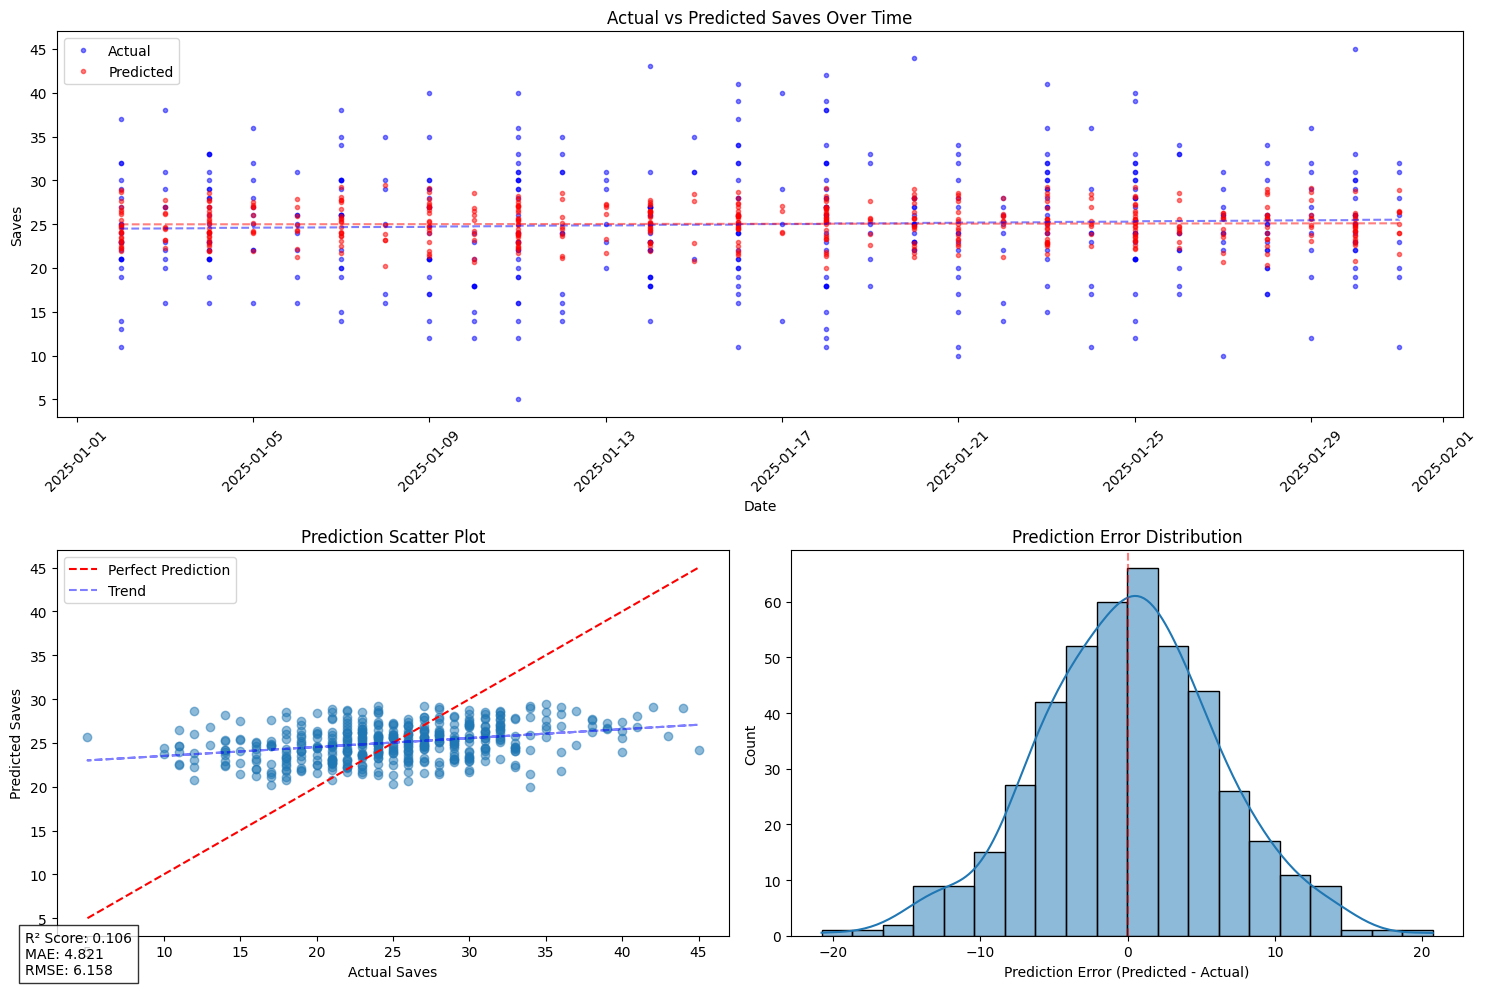


Error Statistics:
Mean Error: 0.061
Error Std Dev: 6.165
Error Range: [-20.767, 20.712]


In [19]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Time series plot (improved version)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
# Add trend lines
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_test)), y_test, 1))(range(len(y_test))), 
         'b--', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_pred)), y_pred, 1))(range(len(y_pred))), 
         'r--', alpha=0.5)
ax1.set_title('Actual vs Predicted Saves Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Saves')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Scatter plot with regression line
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test, p(y_test), "b--", alpha=0.5, label='Trend')
ax2.set_xlabel('Actual Saves')
ax2.set_ylabel('Predicted Saves')
ax2.set_title('Prediction Scatter Plot')
ax2.legend()

# 3. Error distribution
ax3 = fig.add_subplot(gs[1, 1])
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=ax3)
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Prediction Error Distribution')
ax3.set_xlabel('Prediction Error (Predicted - Actual)')
ax3.set_ylabel('Count')

# Add metrics text box
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")

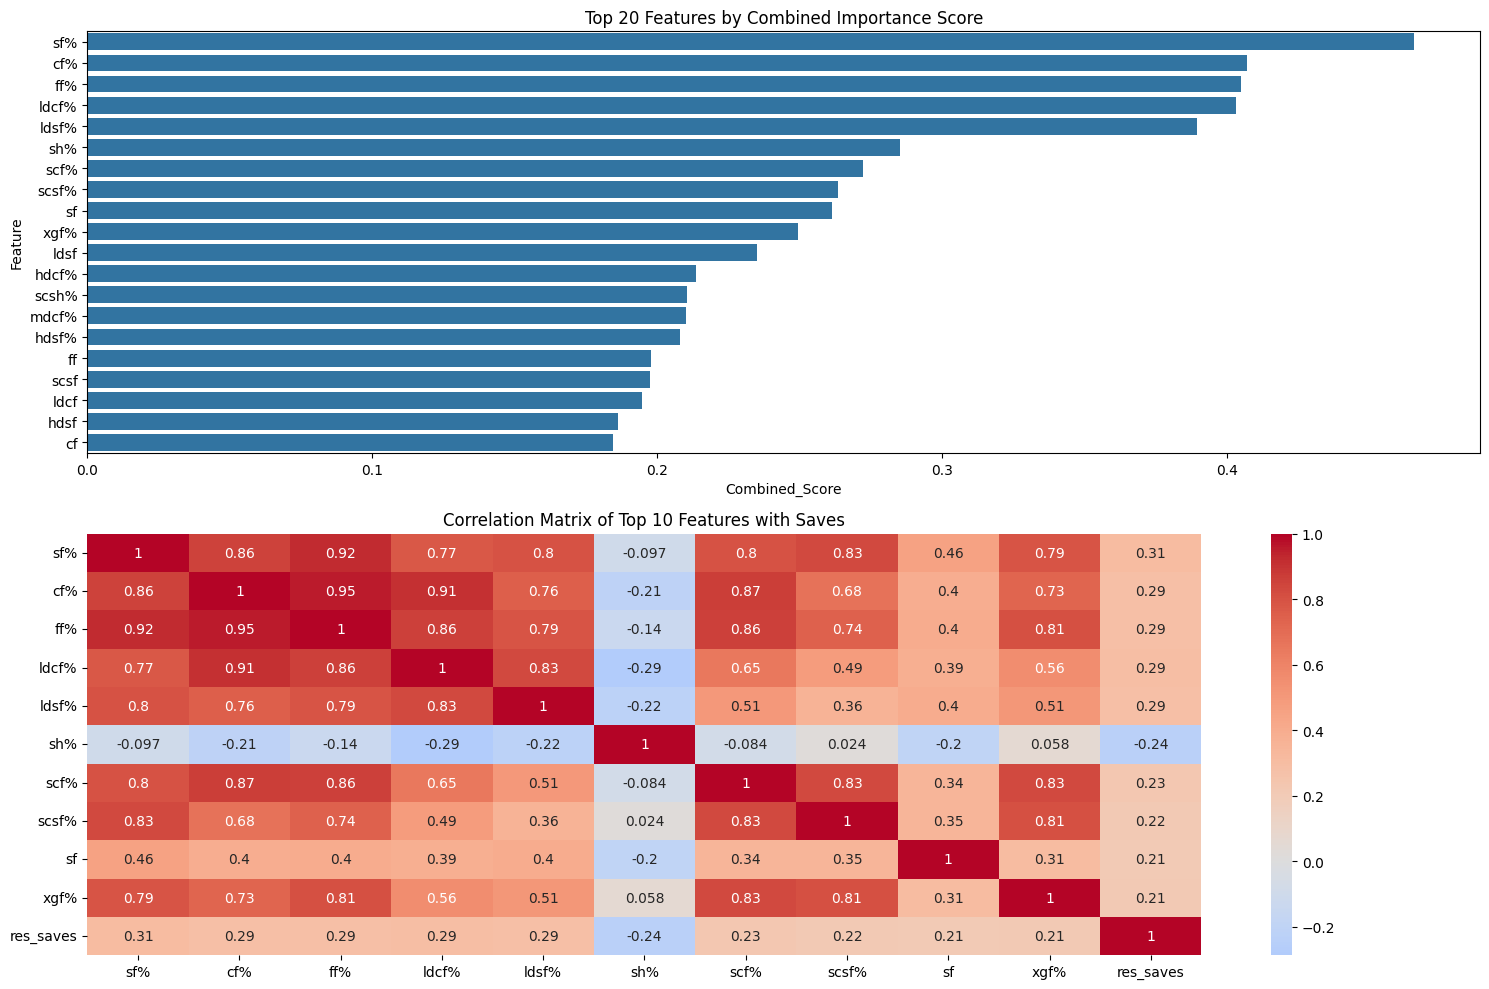


Top 20 Most Important Features for Predicting Saves:
   Feature  Combined_Score  Correlation  PCA_Importance  F_Score_Norm
9      sf%        0.465330     0.310991        0.085000      1.000000
3      cf%        0.406851     0.290034        0.072713      0.857805
6      ff%        0.404565     0.287458        0.084975      0.841263
51   ldcf%        0.403079     0.291465        0.050694      0.867077
54   ldsf%        0.389297     0.286605        0.045452      0.835833
59     sh%        0.285173     0.240626        0.040887      0.574005
18    scf%        0.272149     0.226273        0.086191      0.503984
21   scsf%        0.263284     0.220535        0.091862      0.477457
7       sf        0.261158     0.207937        0.153462      0.422074
15    xgf%        0.249463     0.211970        0.097038      0.439381
52    ldsf        0.235031     0.196244        0.134756      0.374092
29   hdcf%        0.213529     0.195021        0.076307      0.369258
25   scsh%        0.210353     0.202

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_features_for_saves_prediction(df):
    # Remove columns we don't want to consider as features
    exclude_cols = [
        'game_date', 'game_id', 'team', 'goalie_name', 'goalie_team', 'goalie_id', 
        'res_decision', 'res_saves', 'res_shots_against', 'res_save_pct', 'res_goals_against'
    ]
    
    # Convert boolean columns to int
    df['home'] = df['home'].astype(int)
    df['b2b'] = df['b2b'].astype(int)
    df['opp_b2b'] = df['opp_b2b'].astype(int)
    
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Create feature matrix and target vector
    X = df[feature_cols].copy()
    y = df['res_saves']
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 1. PCA Analysis
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # 2. Direct correlation with target
    correlations = []
    for col in feature_cols:
        corr = df[col].corr(y)
        correlations.append((col, abs(corr)))
    
    correlation_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
    correlation_df = correlation_df.sort_values('Correlation', ascending=False)
    
    # 3. Feature selection using f_regression
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X_scaled, y)
    f_scores = selector.scores_
    
    # Combine all feature importance metrics
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'PCA_Importance': np.abs(pca.components_[0]),
        'Correlation': [abs(df[col].corr(y)) for col in feature_cols],
        'F_Score': f_scores
    })
    
    # Normalize F-scores
    feature_importance_df['F_Score_Norm'] = feature_importance_df['F_Score'] / feature_importance_df['F_Score'].max()
    
    # Calculate combined importance score
    feature_importance_df['Combined_Score'] = (
        feature_importance_df['PCA_Importance'] + 
        feature_importance_df['Correlation'] + 
        feature_importance_df['F_Score_Norm']
    ) / 3
    
    feature_importance_df = feature_importance_df.sort_values('Combined_Score', ascending=False)
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Top 20 Features by Combined Score
    plt.subplot(2, 1, 1)
    sns.barplot(data=feature_importance_df.head(20), 
                x='Combined_Score', y='Feature')
    plt.title('Top 20 Features by Combined Importance Score')
    
    # Plot 2: Correlation Matrix of Top Features with Target
    plt.subplot(2, 1, 2)
    top_features = feature_importance_df.head(10)['Feature'].tolist() + ['res_saves']
    correlation_matrix = df[top_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Top 10 Features with Saves')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\nTop 20 Most Important Features for Predicting Saves:")
    print(feature_importance_df[['Feature', 'Combined_Score', 'Correlation', 'PCA_Importance', 'F_Score_Norm']].head(20))
    
    # Group features by type
    feature_groups = {
        'Goalie Performance': [col for col in feature_cols if col.startswith('g_')],
        'Team Stats': ['cf%', 'ff%', 'sf%', 'gf%', 'xgf%', 'scf%', 'hdcf%'],
        'Game Context': ['home', 'b2b', 'opp_b2b'],
        'Shot Quality': ['hdsv%', 'mdsv%', 'ldsv%']
    }
    
    print("\nAverage Importance by Feature Group:")
    for group, features in feature_groups.items():
        group_importance = feature_importance_df[
            feature_importance_df['Feature'].isin(features)
        ]['Combined_Score'].mean()
        print(f"{group}: {group_importance:.4f}")
    
    return feature_importance_df

# Run the analysis
feature_importance_df = analyze_features_for_saves_prediction(processed_df)

Starting grid search...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_es

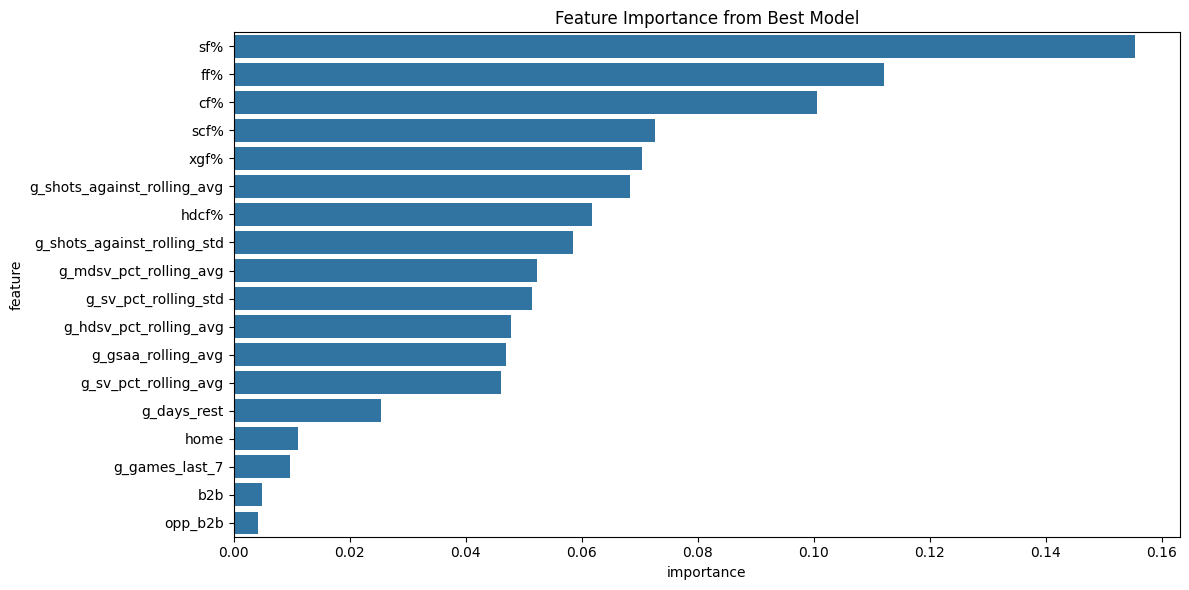

In [217]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
    'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
    'g_games_last_7', 'g_days_rest',
    'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_saves']

# Handle missing values
X = X.fillna(X.mean())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the grid search
print("Starting grid search...")
grid_search.fit(X_scaled, y)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Get detailed CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

print("\nTop 5 parameter combinations:")
top_5_params = cv_results[['params', 'mean_test_score', 'std_test_score']].head()
top_5_params['rmse'] = np.sqrt(-top_5_params['mean_test_score'])
print(top_5_params)

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

# Train final model with best parameters
best_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_scaled, y)

# Get feature importance from best model
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance from best model:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()


Total number of parameter combinations: 1728
Total number of fits: 8640

Starting grid search...
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits

Best parameters found:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 0, 'subsample': 0.8}

Best score:
RMSE: 6.4235

Final Model Metrics:
R² Score: 0.094
MAE: 4.876
RMSE: 6.200


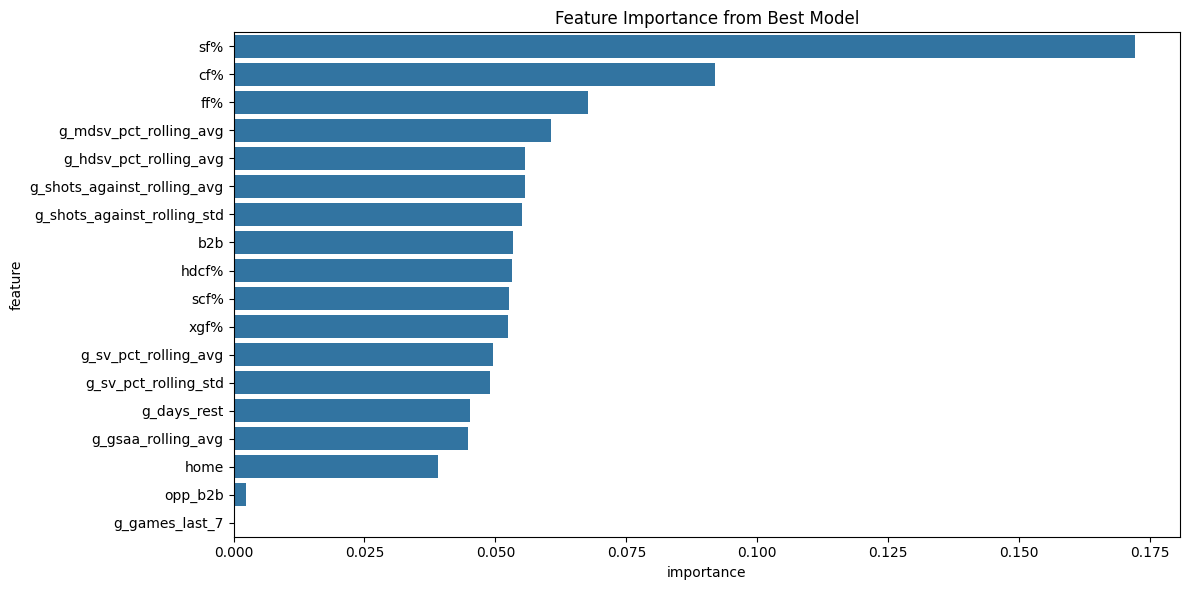

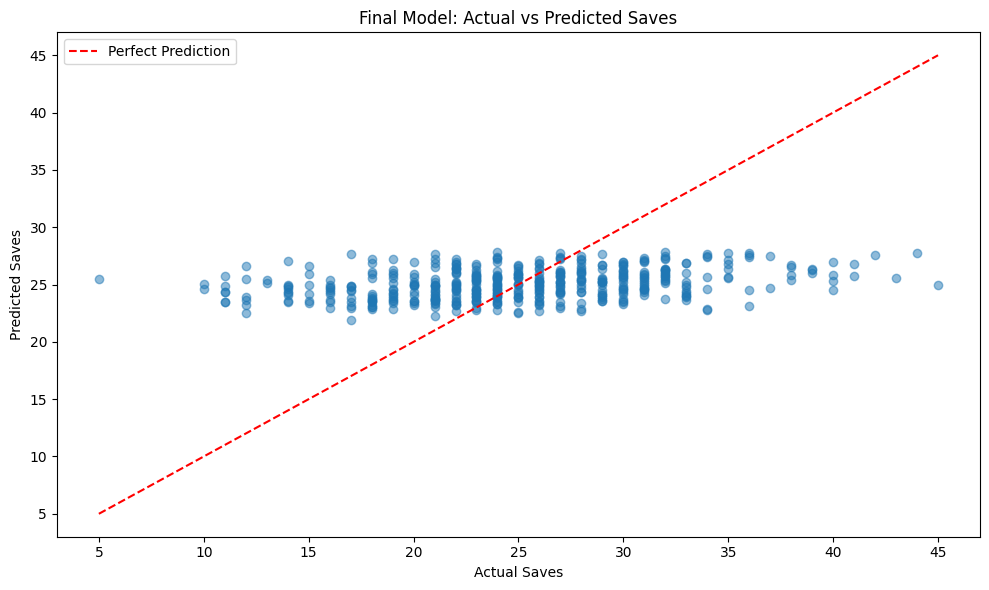

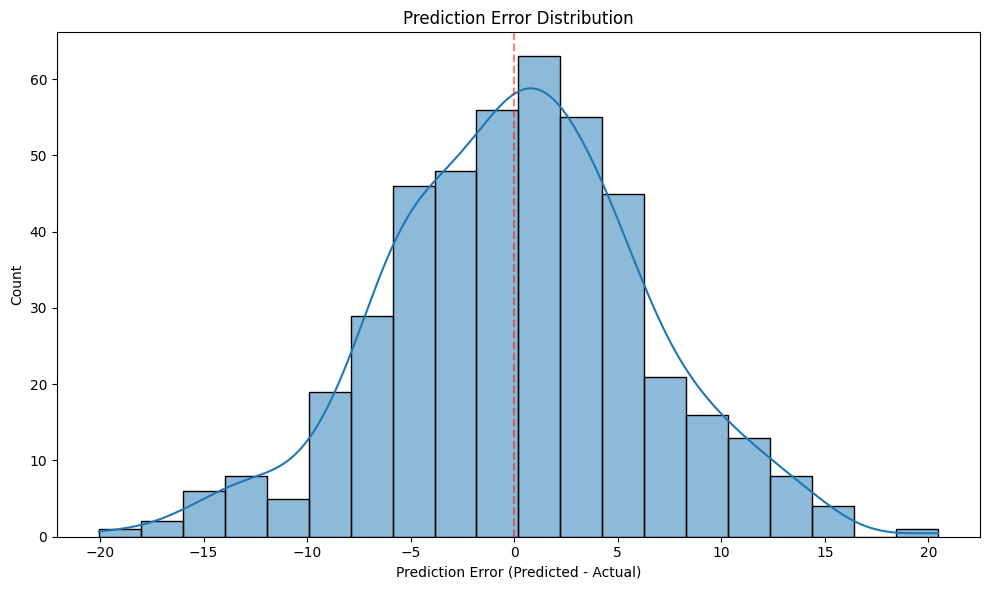


Total execution time: 629.82 seconds


In [28]:
# ... (previous imports and data preparation code remains the same)

# Define a more balanced parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 1.0],
    'reg_lambda': [0, 1.0]
}

# Initialize the model without early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Calculate and print total number of combinations
n_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal number of parameter combinations: {n_combinations}")
print(f"Total number of fits: {n_combinations * 5}")  # 5 is the number of CV splits

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("\nStarting grid search...")
# Actually run the grid search
grid_search.fit(X_train_scaled, y_train)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Train final model with best parameters and early stopping
final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    early_stopping_rounds=50
)

# Fit final model with validation set for early stopping
final_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate metrics
final_metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
}

print("\nFinal Model Metrics:")
print(f"R² Score: {final_metrics['r2_score']:.3f}")
print(f"MAE: {final_metrics['mae']:.3f}")
print(f"RMSE: {final_metrics['rmse']:.3f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Saves')
plt.ylabel('Predicted Saves')
plt.title('Final Model: Actual vs Predicted Saves')
plt.legend()
plt.tight_layout()
plt.show()

# Plot prediction errors
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Epoch 1/100


c:\Users\H-100\Desktop\python\accurateshothelper\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 666.3204 - mae: 24.8297 - mse: 666.3204 - val_loss: 648.7203 - val_mae: 24.6393 - val_mse: 648.7203 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 642.1102 - mae: 24.5407 - mse: 642.1102 - val_loss: 638.3730 - val_mae: 24.4505 - val_mse: 638.3730 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 642.3680 - mae: 24.4625 - mse: 642.3680 - val_loss: 624.8415 - val_mae: 24.1909 - val_mse: 624.8415 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 621.1103 - mae: 24.0644 - mse: 621.1103 - val_loss: 607.4011 - val_mae: 23.8422 - val_mse: 607.4011 - learning_rate: 0.0010
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 603.3116 - mae: 23.6740 - mse: 603.3116 - val_loss: 581.8166 - val_mae: 23.3094 - val_mse: 581.8166 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 576.4394 - mae: 23.1039 - mse: 576.439

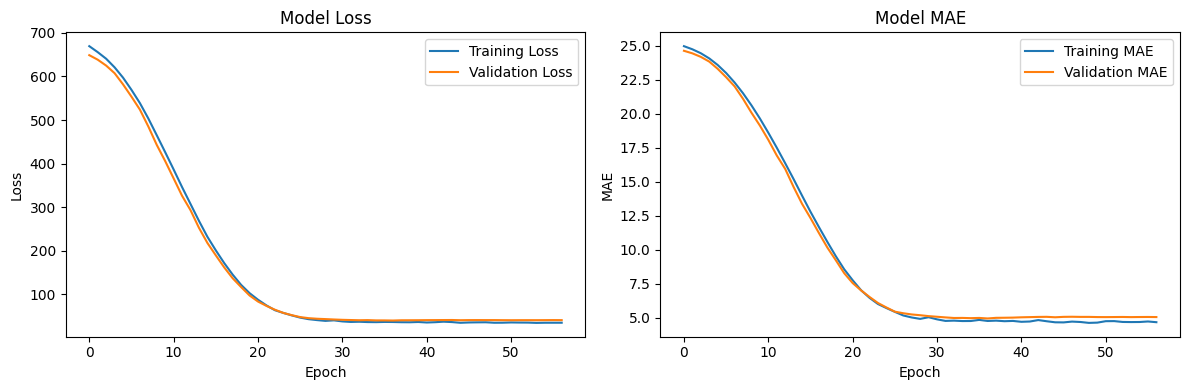


ANN Model Metrics:
R² Score: 0.055
MAE: 4.932
RMSE: 6.331


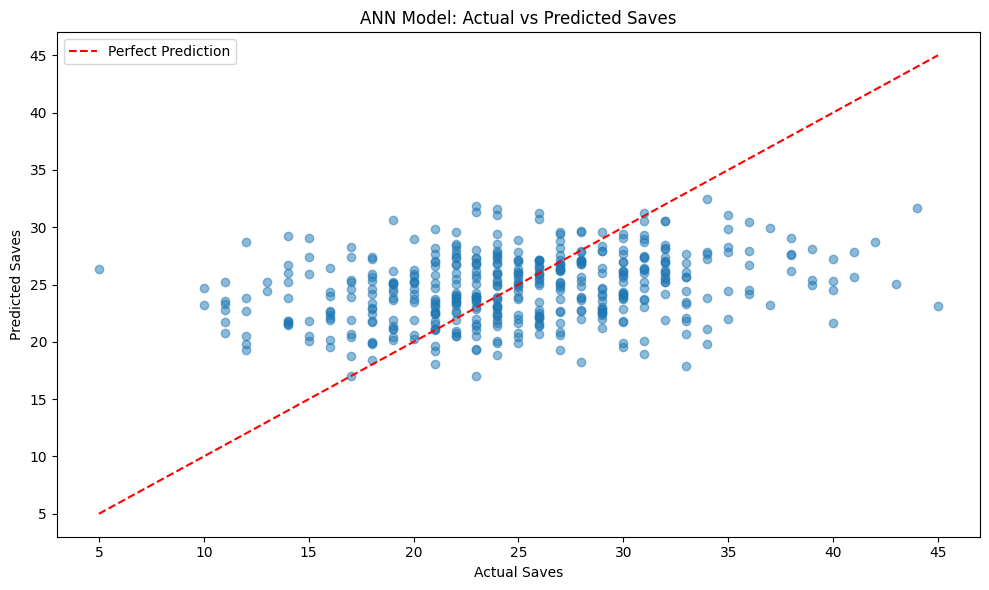

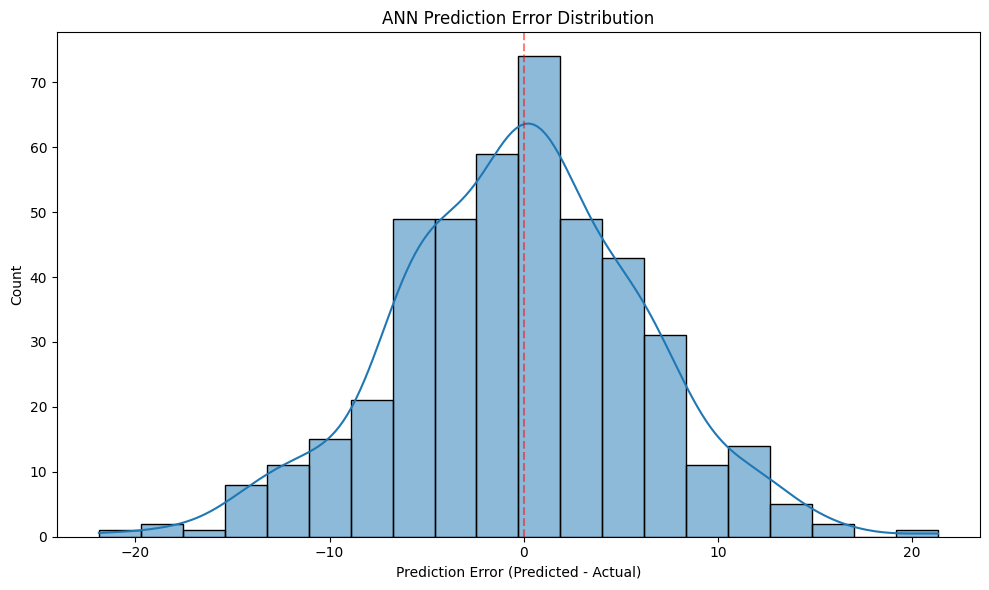

In [29]:
import tensorflow as tf

def create_ann_model(input_dim, learning_rate=0.001):
    """
    Creates an ANN model for goalie save prediction.
    
    Args:
        input_dim (int): Number of input features
        learning_rate (float): Learning rate for the optimizer
        
    Returns:
        tf.keras.Model: Compiled ANN model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1)  # Output layer for regression
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

def train_ann_model(X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    """
    Trains the ANN model with early stopping and learning rate reduction.
    
    Args:
        X_train, y_train: Training data
        X_test, y_test: Testing data
        epochs (int): Maximum number of epochs
        batch_size (int): Batch size for training
        
    Returns:
        tuple: (trained model, training history)
    """
    # Create callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
    
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )
    
    # Create and train model
    model = create_ann_model(X_train.shape[1])
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, lr_reducer],
        verbose=1
    )
    
    return model, history

# Train the ANN model
ann_model, history = train_ann_model(X_train_scaled, y_train, X_test_scaled, y_test)

# Evaluate the model
y_pred_ann = ann_model.predict(X_test_scaled)
metrics_ann = {
    'r2_score': r2_score(y_test, y_pred_ann),
    'mae': mean_absolute_error(y_test, y_pred_ann),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_ann))
}

# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Print metrics
print("\nANN Model Metrics:")
print(f"R² Score: {metrics_ann['r2_score']:.3f}")
print(f"MAE: {metrics_ann['mae']:.3f}")
print(f"RMSE: {metrics_ann['rmse']:.3f}")

# Compare predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ann, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Saves')
plt.ylabel('Predicted Saves')
plt.title('ANN Model: Actual vs Predicted Saves')
plt.legend()
plt.tight_layout()
plt.show()

# Plot error distribution
errors_ann = y_pred_ann.flatten() - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors_ann, kde=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title('ANN Prediction Error Distribution')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [4]:
def predict_next_game(goalie_history, model, scaler, window_size=10):
    """Predict save percentage for next game"""
    X, _ = prepare_features(goalie_history, window_size)
    X_latest = X.iloc[[-1]]  # Get most recent game's features
    X_scaled = scaler.transform(X_latest)
    
    predicted_sv = model.predict(X_scaled)[0]
    return predicted_sv

def calculate_performance_scalar(predicted_sv, league_avg_sv=0.910):
    """Convert predicted save percentage to performance scalar"""
    sv_diff = predicted_sv - league_avg_sv
    return 1 - sv_diff

In [ ]:
# Now let's evaluate the model
processed_data = prepare_game_data(goalie_stats)
model, scaler, metrics = train_model(processed_data)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f}")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f}")

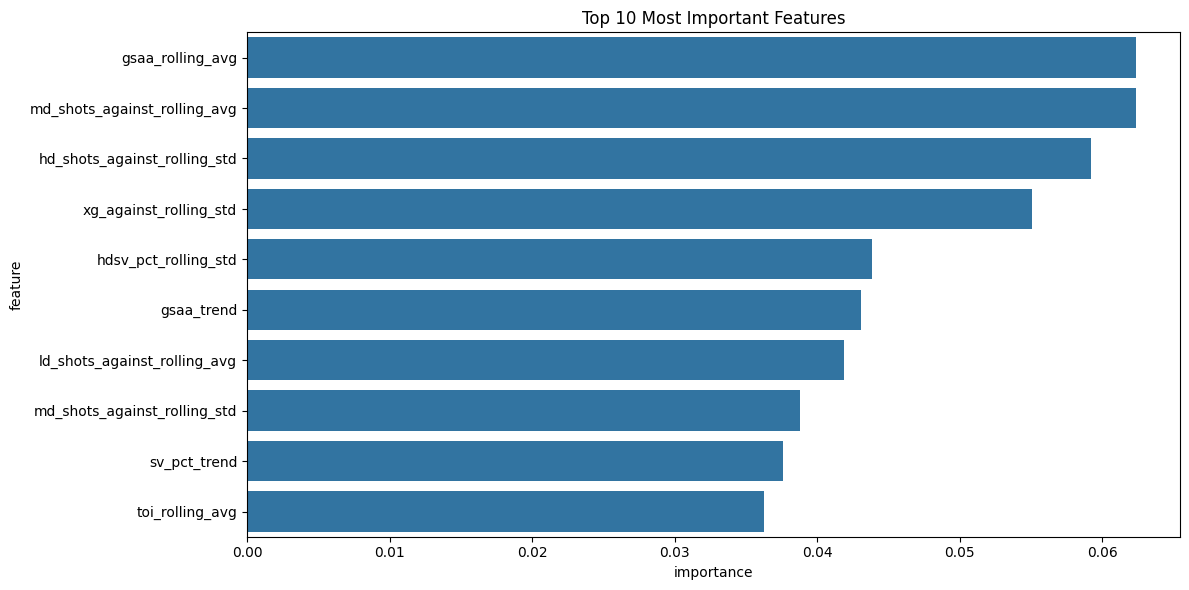

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'feature': list(metrics['feature_importance'].keys()),
    'importance': list(metrics['feature_importance'].values())
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

Original data length: 21
Predictions length: 21
X_scaled shape: (21, 28)


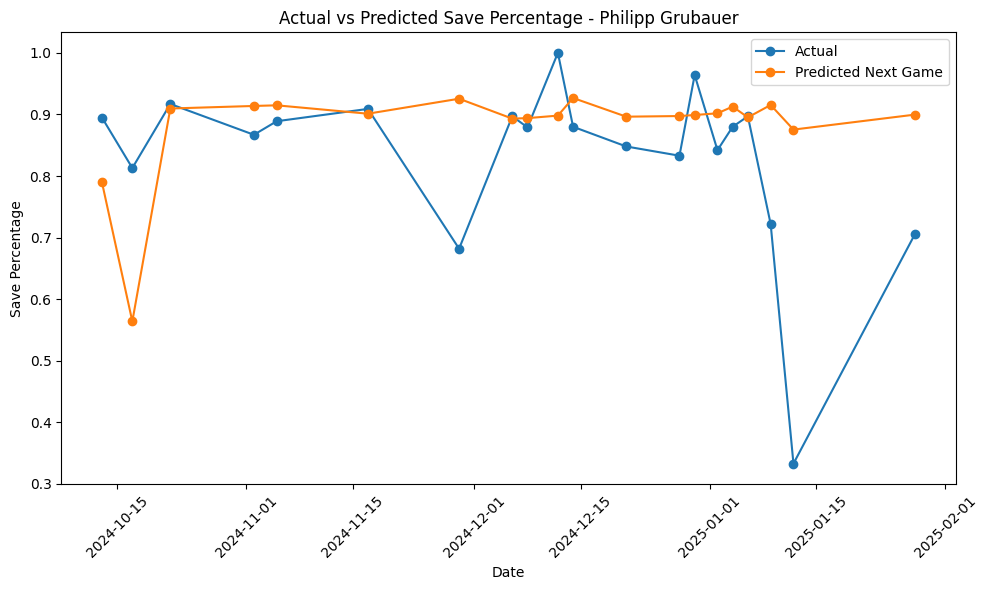


Predicted save percentage for Philipp Grubauer's next game: 0.837


In [ ]:
# Plot actual vs predicted values for a specific goalie
goalie_name = 'Philipp Grubauer'
goalie_data = processed_data[processed_data['player'] == goalie_name].copy()  # Make a copy
X, processed_df = prepare_features(goalie_data)
X_scaled = scaler.transform(X)
predictions = model.predict(X_scaled)

# Print dimensions to debug
print(f"Original data length: {len(goalie_data)}")
print(f"Predictions length: {len(predictions)}")
print(f"X_scaled shape: {X_scaled.shape}")

# Create the plot with aligned data
plt.figure(figsize=(10, 6))
# Use the same date range for both actual and predicted values
dates = goalie_data['date'].iloc[:-1]  # Remove last date
actual_values = goalie_data['sv_pct'].iloc[:-1]  # Remove last actual value

plt.plot(dates, actual_values, label='Actual', marker='o')
plt.plot(dates, predictions[:-1], label='Predicted Next Game', marker='o')
plt.title(f'Actual vs Predicted Save Percentage - {goalie_name}')
plt.xlabel('Date')
plt.ylabel('Save Percentage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the prediction for the next game
print(f"\nPredicted save percentage for {goalie_name}'s next game: {predictions[-1]:.3f}")

In [46]:
performance_scalar

1.0187401996962557

In [47]:
g

NameError: name 'g' is not defined